In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [3]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


## ↓↓↓↓↓↓↓ 전처리 수정 ↓↓↓↓↓↓↓↓↓
1. 괄호 및 괄호 안 텍스트 제거 (re.sub(r"\(.*?\)", "", sentence))
2. 특수 문자 제거 (한글, 영어, 숫자, 문장 부호만 남김)
3. 한문 → 한글 음 변환 (hanja.translate())
4. 타겟 데이터(영어)에 \<start\>와 \<end\> 추가

In [27]:
enc_train_data = 'korean-english-park.train.ko'
dec_train_data = 'korean-english-park.train.en'
enc_val_data = 'korean-english-park.dev.ko'
dec_val_data = 'korean-english-park.dev.en'
enc_test_data = 'korean-english-park.test.ko'
dec_test_data = 'korean-english-park.test.en'
ko_sample_train_data = 'korean-english-sampled.ko'
en_sample_train_data = 'korean-english-sampled.en'

# 데이터 읽기
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return data

# 파일 읽기
enc_train_data = load_data(enc_train_data)
dec_train_data = load_data(dec_train_data)
enc_val_data = load_data(enc_val_data)
dec_val_data = load_data(dec_val_data)
enc_test_data = load_data(enc_test_data)
dec_test_data = load_data(dec_test_data)
ko_sample_train_data = load_data(ko_sample_train_data)
en_sample_train_data = load_data(en_sample_train_data)


# 데이터 미리 보기
print(ko_sample_train_data[:3])
print(en_sample_train_data[:3])# 첫 3개 항목 확인

['그녀의 이 같은 부인은 박 전 대표의 측근이 이 전 시장의 도덕성에 의문을 제기하는 주장으로 서로 갈등이 심화하는 가운데 나왔다.\n', '스티비 닉스는 기타 하나로 십대 소년들의 우상이 됐었다.\n', '한 미국 상원의원이 북한의 비핵화에 대한 주요 보상 중 하나인, 미국의 테러지원국 목록에서 북한을 삭제하는 것에 대해 조건을 설정하자는 결의안을 제시했다.\n']
["Her denial comes amid an intensifying war of words triggered by a Park aide's allegations that question Lee's morality.\n", 'True, looks have always been a part of the music business:\n', 'A senior U.S. senator introduced a resolution setting conditions for removing North Korea from the U.S. list of terrorism-sponsoring nations, one of the key incentives offered for Pyongyang´s denuclearization.\n']


In [6]:
# enc_data = enc_train_data + enc_val_data
# dec_data = dec_train_data + dec_val_data

In [7]:
# len(enc_train_data)

94123

In [8]:
# len(enc_val_data)

1000

In [13]:
# 특수기호 확인하는 함수
def find_special_char(data):
    # 한글과 숫자를 제외한 특수문자만 찾는 정규표현식
    pattern = r'[^가-힣0-9a-zA-Z\s]'
    
    special_chars = []
    
    # 리스트의 각 항목에 대해 특수기호를 찾음
    for text in data:
        if isinstance(text, str):  # 문자열인 경우에만 처리
            # 정규표현식을 통해 특수문자 추출
            special_chars.extend(re.findall(pattern, text))
    
    return special_chars

In [14]:
set(find_special_char(ko_sample_train_data))

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '±',
 '´',
 '·',
 '×',
 'é',
 '˝',
 '–',
 '‘',
 '’',
 '“',
 '”',
 '•',
 '…',
 'ℓ',
 '▲',
 '▶',
 'い',
 'き',
 'く',
 'さ',
 'ざ',
 'し',
 'す',
 'そ',
 'ば',
 'ぶ',
 'ま',
 'や',
 'よ',
 'ら',
 'ん',
 '㈜',
 '㎞',
 '㎠',
 '㎡',
 '㎢',
 '㎾',
 '万',
 '上',
 '不',
 '中',
 '主',
 '九',
 '亞',
 '交',
 '促',
 '假',
 '僞',
 '兆',
 '光',
 '克',
 '公',
 '前',
 '力',
 '勝',
 '區',
 '占',
 '卿',
 '反',
 '古',
 '吉',
 '同',
 '名',
 '吾',
 '器',
 '四',
 '國',
 '園',
 '地',
 '型',
 '城',
 '基',
 '報',
 '場',
 '多',
 '大',
 '夫',
 '奔',
 '子',
 '孩',
 '宇',
 '家',
 '富',
 '察',
 '寶',
 '寺',
 '對',
 '局',
 '山',
 '川',
 '州',
 '市',
 '席',
 '平',
 '幹',
 '庫',
 '廣',
 '弗',
 '强',
 '影',
 '後',
 '心',
 '性',
 '戰',
 '手',
 '掌',
 '播',
 '故',
 '敎',
 '敵',
 '新',
 '方',
 '旗',
 '日',
 '早',
 '星',
 '時',
 '書',
 '會',
 '朱',
 '李',
 '機',
 '權',
 '次',
 '死',
 '母',
 '毛',
 '泰',
 '流',
 '浅',
 '海',
 '淺',
 '港',
 '湖',
 '溫',
 '滑',
 '澤',
 '濠'

In [15]:
set(find_special_char(en_sample_train_data))

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '~',
 '¡',
 '¢',
 '£',
 '¥',
 '¦',
 '¨',
 '®',
 '¯',
 '°',
 '±',
 '´',
 'µ',
 '·',
 '¹',
 'º',
 '»',
 '½',
 '¾',
 '¿',
 'À',
 'Á',
 'Â',
 'Ç',
 'Ê',
 'Ï',
 'Ñ',
 'Ù',
 'Û',
 'â',
 'æ',
 'ç',
 'ö',
 'ø',
 'û',
 '˝',
 '–',
 '―',
 '‘',
 '’',
 '“',
 '”',
 '…'}

In [17]:
!pip install hanja

     |████████████████████████████████| 124 kB 4.1 MB/s            
     |████████████████████████████████| 343 kB 23.2 MB/s            
     |████████████████████████████████| 738 kB 44.2 MB/s            
     |████████████████████████████████| 236 kB 105.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=9d201cb119657b54c7bf41e909f642e973d468e65b28f03224e14f6666ce3943
  Stored in directory: /aiffel/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [28]:
import re
import hanja

def preprocess_sentence(sentence, s_token=False, e_token=False, is_korean=False):
    
    sentence = sentence.strip()
    
    #괄호 및 괄호 안 텍스트 제거
    sentence = re.sub(r"\(.*?\)", "", sentence)

    # 한문 → 한글 발음 변환 (한글 데이터에만 적용)
    if is_korean:
        sentence = hanja.translate(sentence, 'substitution')

    # 특수 문자 제거 (한글, 영어, 숫자, 주요 문장부호만 유지)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  # 문장부호 앞뒤 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)  # 연속된 공백 제거
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)  # 허용된 문자 이외 제거
    
    sentence = sentence.strip()

    # 영어 문장에 <start> <end> 토큰 추가
    if s_token:
        sentence = '<start> ' + sentence
    if e_token:
        sentence += ' <end>'
    
    return sentence

In [29]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for kor in ko_sample_train_data[:num_examples]:
    enc_corpus.append(preprocess_sentence(kor, is_korean=True))

for eng in en_sample_train_data[:num_examples]:
    dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

print("한국어:", enc_corpus[100])
print("영어:", dec_corpus[100])

한국어: 교과서 왜곡을 통해 동해에 있는 바위섬 독도에 대한 소유권을 주장하려는 최근의 일본의 행위에 대해 한국 정부가 강하게 항의했다 .
영어: <start> South Korea Thursday strongly protested Japan s recent efforts to step up its claim to Dokdo , a group of rocky islets in the East Sea , through an explicit distortion of textbooks . <end>


In [34]:
import random

def fix_random_seeds(seed=42):
    # Python random 시드 고정
    random.seed(seed)
    # NumPy random 시드 고정
    np.random.seed(seed)
    # TensorFlow random 시드 고정
    tf.random.set_seed(seed)

# 고정할 시드값 설정
fix_random_seeds(42)

In [31]:
import nltk
import MeCab
import tensorflow as tf

In [32]:
nltk.download('punkt')
mecab = MeCab.Tagger()

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [35]:
def tokenize(corpus, lang='ko'):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

    tokenized_corpus = []
    
    for sentence in corpus:
        if lang == 'ko':  # 한국어 텍스트일 경우 MeCab 사용
            parsed = mecab.parse(sentence)
            tokens = [line.split('\t')[0] for line in parsed.splitlines() if line]
        elif lang == 'en':  # 영어 텍스트일 경우 NLTK 사용
            tokens = nltk.word_tokenize(sentence)
        else:
            raise ValueError("Language should be either 'ko' or 'en'.")

        # 리스트에 토큰 추가
        tokenized_corpus.append(' '.join(tokens))
    
    tokenizer.fit_on_texts(tokenized_corpus)  # 토큰을 기반으로 Tokenizer 학습
    
    # 특수 토큰 추가
    tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
    tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 2
    
    tensor = tokenizer.texts_to_sequences(tokenized_corpus)  # 텍스트를 시퀀스로 변환
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  # 시퀀스 길이를 동일하게 맞추기

    return tensor, tokenizer


In [44]:
import numpy as np
import json

enc_corpus, enc_tokenizer = tokenize(enc_corpus, lang='ko')
dec_corpus, dec_tokenizer = tokenize(dec_corpus, lang='en')

# 토큰화된 데이터 저장 (npz 형식)
np.savez_compressed("tokenized_data.npz", enc_corpus=enc_corpus, dec_corpus=dec_corpus)
print("tokenized_data.npz")

# 단어 사전 저장 (json 형식)
with open("enc_tokenizer.json", "w", encoding="utf-8") as f:
    json.dump(enc_tokenizer.word_index, f, ensure_ascii=False, indent=4)

with open("dec_tokenizer.json", "w", encoding="utf-8") as f:
    json.dump(dec_tokenizer.word_index, f, ensure_ascii=False, indent=4)

print("enc_tokenizer.json, dec_tokenizer.json")


tokenized_data.npz
enc_tokenizer.json, dec_tokenizer.json


----

In [55]:
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_corpus, dec_corpus, test_size=0.2)

In [45]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [46]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [47]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [48]:
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 512
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 30, 512)
Decoder Output: (32, 30368)
Decoder Hidden State: (32, 512)
Attention: (32, 30, 1)


In [49]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [50]:
# 체크포인트 설정 (베스트 모델 저장)
def create_checkpoint_manager(encoder, decoder, optimizer, checkpoint_dir='./checkpoints'):
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
    manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=1)
    return checkpoint, manager

In [51]:
from tqdm import tqdm
import random

In [52]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [53]:
# 체크포인트 설정
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

best_val_loss = float('inf')  # 초기 검증 손실

In [54]:
# eval_step 함수 정의
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [56]:
EPOCHS = 10
# Training Process
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list, desc=f"Epoch {epoch + 1}")

    # 학습 (Training)
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_postfix(loss=f"{total_loss.numpy() / (batch + 1):.4f}")
    
    # 검증 (Validation)
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list, desc=f"Test Epoch {epoch + 1}")

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_postfix(test_loss=f"{test_loss.numpy() / (test_batch + 1):.4f}")
    
    avg_val_loss = test_loss.numpy() / len(t)  # 검증 손실 평균

    # 베스트 모델 체크포인트 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint_manager.save()
        print("모델 체크포인트 저장 완료!")

Test Epoch 1: 100%|██████████| 188/188 [01:26<00:00,  2.18it/s, test_loss=2.1561]


모델 체크포인트 저장 완료!


Test Epoch 10: 100%|██████████| 188/188 [00:30<00:00,  6.17it/s, test_loss=2.1874]


In [58]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [59]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

Input: 오바마는 대통령이다 .
Predicted translation: > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


/tmp/ipykernel_77/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_77/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


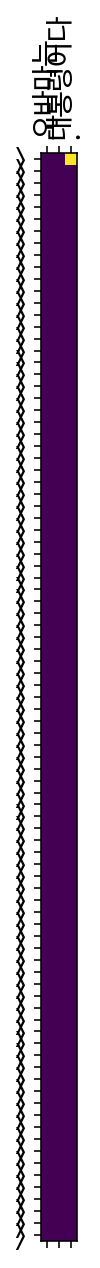

Input: 시민들은 도시 속에 산다 .
Predicted translation: > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


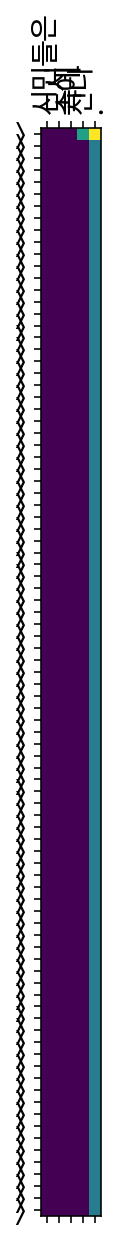

Input: 커피는 필요 없다 .
Predicted translation: > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


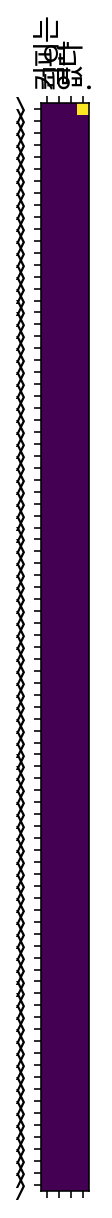

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 


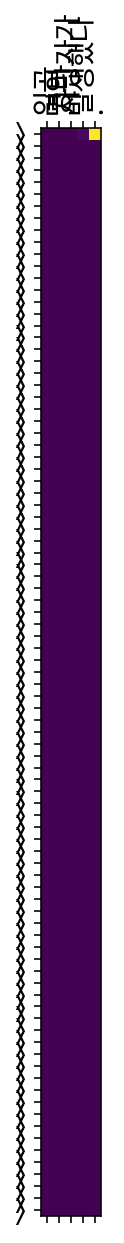

In [61]:
input_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

def translate(sentences, encoder, decoder):
    for sentence in sentences:  # 개별 문장 처리
        result, processed_sentence, attention = evaluate(sentence, encoder, decoder)

        print('Input: %s' % (processed_sentence))  # 변환된 문장 출력
        print('Predicted translation: {}'.format(result))

        # Attention 크기 조정 (잘못된 크기 방지)
        attention = attention[:len(result.split()), :len(processed_sentence.split())]
        plot_attention(attention, processed_sentence.split(), result.split(' '))

# 실행 (input_sentences 리스트 전달)
translate(input_sentences, encoder, decoder)

#### 결과가 이상하다 ㅠㅠ
밤에 zep에 창원님이 계셔서 얘기해보니 코드 자체에 문제가 있었던 것 같습니다   
토크나이즈가 좀 잘못 된 것 같기도 하고   
인코더 디코더 구조 자체를 잘못 연결했을 수도 있을 것 같다